In [1]:
import math
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("device:", device)

# Helpful on recent PyTorch versions (optional)
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

torch.manual_seed(0)


device: mps


In [ ]:
def load_text(path="data/input.txt"):
    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as f:
            return f.read()
    print("⚠️ input.txt not found. Using tiny fallback text (too small for good results).")
    return (
        "This is a tiny dataset. Add input.txt with more text for real training.\n"
        "Mini GPT learns to predict the next character based on previous characters.\n"
    )

text = load_text("input.txt")
print("text length:", len(text))
print(text[:300])

text length: 20450
## Part 0 — Foundation: The Quiet Empire of Light (Year 3026)

By 3026, humanity didn’t feel like a nation so much as a phase change.

We never “conquered” the Milky Way. We **grew through it**—first by stubborn chemistry, then by careful engineering—until our presence looked less like colonization 


In [3]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}

def encode(s: str):
    return [stoi[c] for c in s]

def decode(ids):
    return "".join(itos[i] for i in ids)

data = torch.tensor(encode(text), dtype=torch.long)
print("vocab_size:", vocab_size)
print("data shape:", data.shape)
print("sample decode:", decode(data[:200].tolist()))

vocab_size: 72
data shape: torch.Size([20450])
sample decode: ## Part 0 — Foundation: The Quiet Empire of Light (Year 3026)

By 3026, humanity didn’t feel like a nation so much as a phase change.

We never “conquered” the Milky Way. We **grew through it**—first 


In [4]:
n = int(0.9 * len(data))
train_data = data[:n]
val_data   = data[n:]

batch_size = 64
block_size = 128  # context length: how many chars the model can "see"

def get_batch(split):
    d = train_data if split == "train" else val_data
    # random starting positions
    ix = torch.randint(0, len(d) - block_size - 1, (batch_size,))
    x = torch.stack([d[i:i+block_size] for i in ix])
    y = torch.stack([d[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

# sanity check
xb, yb = get_batch("train")
print("xb:", xb.shape, xb.dtype, xb.device)
print("yb:", yb.shape, yb.dtype, yb.device)


xb: torch.Size([64, 128]) torch.int64 mps:0
yb: torch.Size([64, 128]) torch.int64 mps:0


In [5]:
class TransformerBlock(nn.Module):
    def __init__(self, n_embd, n_head, dropout):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embd)
        self.attn = nn.MultiheadAttention(n_embd, n_head, dropout=dropout, batch_first=True)
        self.ln2 = nn.LayerNorm(n_embd)
        self.mlp = nn.Sequential(
            nn.Linear(n_embd, 4*n_embd),
            nn.GELU(),
            nn.Linear(4*n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        # x: (B, T, C)
        B, T, C = x.shape
        # causal mask: block attending to future positions
        causal_mask = torch.triu(torch.ones(T, T, device=x.device, dtype=torch.bool), diagonal=1)
        # self-attention
        x_norm = self.ln1(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm, attn_mask=causal_mask, need_weights=False)
        x = x + attn_out
        # feedforward
        x = x + self.mlp(self.ln2(x))
        return x

class MiniGPT(nn.Module):
    def __init__(self, vocab_size, block_size, n_layer=4, n_head=4, n_embd=128, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.block_size = block_size

        self.tok_emb = nn.Embedding(vocab_size, n_embd)
        self.pos_emb = nn.Embedding(block_size, n_embd)
        self.drop = nn.Dropout(dropout)

        self.blocks = nn.ModuleList([
            TransformerBlock(n_embd, n_head, dropout) for _ in range(n_layer)
        ])
        self.ln_f = nn.LayerNorm(n_embd)
        self.head = nn.Linear(n_embd, vocab_size, bias=False)

    def forward(self, idx, targets=None):
        # idx: (B, T)
        B, T = idx.shape
        assert T <= self.block_size, "Sequence too long for block_size"

        pos = torch.arange(T, device=idx.device)  # (T,)
        x = self.tok_emb(idx) + self.pos_emb(pos)  # (B, T, C)
        x = self.drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.ln_f(x)
        logits = self.head(x)  # (B, T, vocab_size)

        loss = None
        if targets is not None:
            # CrossEntropy expects (B*T, V) and targets (B*T)
            loss = F.cross_entropy(logits.view(B*T, -1), targets.view(B*T))

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens=200, temperature=1.0, top_k=None):
        # idx: (B, T)
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]  # crop context
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature  # last step
            if top_k is not None:
                v, _ = torch.topk(logits, top_k)
                logits[logits < v[:, [-1]]] = -float("inf")
            probs = F.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)  # (B,1)
            idx = torch.cat([idx, next_id], dim=1)
        return idx

model = MiniGPT(vocab_size, block_size, n_layer=4, n_head=4, n_embd=128, dropout=0.1).to(device)
print("params:", sum(p.numel() for p in model.parameters())/1e6, "M")


params: 0.82816 M


In [6]:
@torch.no_grad()
def estimate_loss(model, eval_iters=50):
    model.eval()
    out = {}
    for split in ["train", "val"]:
        losses = []
        for _ in range(eval_iters):
            xb, yb = get_batch(split)
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = sum(losses) / len(losses)
    model.train()
    return out


step    0 | train 4.3175 | val 4.3176
step  200 | train 2.4888 | val 2.5443
step  400 | train 2.3929 | val 2.4530
step  600 | train 2.2677 | val 2.3505
step  800 | train 2.0409 | val 2.2021
step 1000 | train 1.8270 | val 2.0927
step 1200 | train 1.5959 | val 2.0715
step 1400 | train 1.3464 | val 2.0665
step 1600 | train 1.0951 | val 2.0911
step 1800 | train 0.8484 | val 2.1729
step 1999 | train 0.6326 | val 2.2943


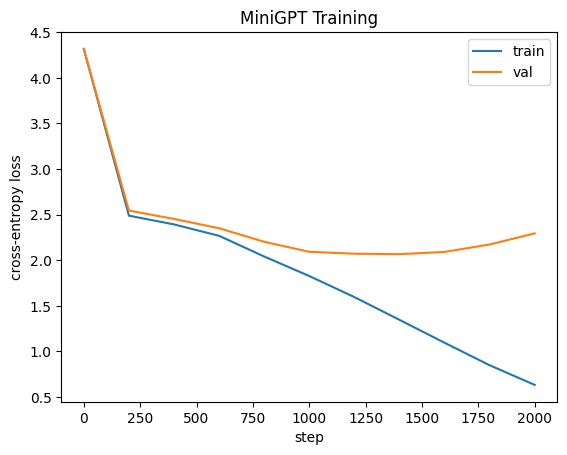

In [7]:
lr = 3e-4
max_steps = 2000
eval_every = 200
grad_clip = 1.0

opt = torch.optim.AdamW(model.parameters(), lr=lr)

train_curve = []
val_curve = []

for step in range(max_steps):
    xb, yb = get_batch("train")
    logits, loss = model(xb, yb)

    opt.zero_grad(set_to_none=True)
    loss.backward()

    # gradient diagnostics / stability
    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

    opt.step()

    if step % eval_every == 0 or step == max_steps - 1:
        losses = estimate_loss(model, eval_iters=30)
        train_curve.append(losses["train"])
        val_curve.append(losses["val"])
        print(f"step {step:4d} | train {losses['train']:.4f} | val {losses['val']:.4f}")

# plot
plt.figure()
plt.plot([i*eval_every for i in range(len(train_curve))], train_curve, label="train")
plt.plot([i*eval_every for i in range(len(val_curve))], val_curve, label="val")
plt.xlabel("step")
plt.ylabel("cross-entropy loss")
plt.title("MiniGPT Training")
plt.legend()
plt.show()


In [8]:
sample = "ab ba\n"
ids = encode(sample)

print("sample:", repr(sample))
print("ids:", ids)
print("decoded:", repr(decode(ids)))

t = torch.tensor(ids, dtype=torch.long)
print("tensor:", t, t.dtype, t.shape)

# show token + position pairs
for i, (ch, tid) in enumerate(zip(sample, ids)):
    print(f"pos {i:2d} | char {repr(ch):>4} | id {tid}")


sample: 'ab ba\n'
ids: [41, 42, 1, 42, 41, 0]
decoded: 'ab ba\n'
tensor: tensor([41, 42,  1, 42, 41,  0]) torch.int64 torch.Size([6])
pos  0 | char  'a' | id 41
pos  1 | char  'b' | id 42
pos  2 | char  ' ' | id 1
pos  3 | char  'b' | id 42
pos  4 | char  'a' | id 41
pos  5 | char '\n' | id 0


In [9]:
prompt = "Hello"
idx = torch.tensor([encode(prompt)], dtype=torch.long, device=device)

model.eval()
with torch.no_grad():
    out = model.generate(idx, max_new_tokens=300, temperature=0.9, top_k=50)
print(decode(out[0].tolist()))


Hellocants, and started of the unive the lie ansones, just closed a start to be king a replening system.

The ship cill fromined, trum dootaisy—resppoing to AIs tewter the photones—nothing shabile metaint—didn’t a namad been centurity became the from deeplication les, because the grefused throat shings t


In [10]:
model.eval()
with torch.no_grad():
    xb, yb = get_batch("val")
    logits, loss = model(xb, yb)

# pick first sample, first position
x0 = xb[0]
y0 = yb[0]
t = 0  # position

true_id = y0[t].item()
true_char = itos[true_id]

logits_t = logits[0, t]  # (V,)
probs_t = F.softmax(logits_t, dim=-1)

topv, topi = torch.topk(probs_t, 10)
print("Context (up to t):", repr(decode(x0[:t+1].detach().cpu().tolist())))
print("True next char:", repr(true_char), "id:", true_id)
print("\nTop-10 predicted next chars:")
for p, i in zip(topv.tolist(), topi.tolist()):
    print(f"  {repr(itos[i])}: {p:.4f}")


Context (up to t): 'c'
True next char: 'i' id: 49

Top-10 predicted next chars:
  'o': 0.1778
  'a': 0.1585
  'h': 0.1068
  'e': 0.1045
  't': 0.0838
  'u': 0.0761
  'l': 0.0747
  'i': 0.0480
  'k': 0.0452
  'r': 0.0338


In [11]:
xb, yb = get_batch("train")

# pick first example in batch
x0 = xb[0].detach().cpu().tolist()
y0 = yb[0].detach().cpu().tolist()

print("x tokens:", x0[:30])
print("y tokens:", y0[:30])

print("\nDecoded x:")
print(repr(decode(x0)))

print("\nDecoded y:")
print(repr(decode(y0)))

print("\nCheck shift property (first 50):")
print("x[1:] == y[:-1] ?", x0[1:50] == y0[:49])


x tokens: [60, 61, 58, 45, 8, 1, 25, 54, 1, 12, 9, 11, 13, 6, 1, 54, 55, 42, 55, 44, 65, 1, 60, 58, 61, 59, 60, 45, 44, 1]
y tokens: [61, 58, 45, 8, 1, 25, 54, 1, 12, 9, 11, 13, 6, 1, 54, 55, 42, 55, 44, 65, 1, 60, 58, 61, 59, 60, 45, 44, 1, 41]

Decoded x:
'ture. In 3026, nobody trusted a single mind—human or machine—to be absolute.\n\nAnd the mission constraint that shaped everything:'

Decoded y:
'ure. In 3026, nobody trusted a single mind—human or machine—to be absolute.\n\nAnd the mission constraint that shaped everything:\n'

Check shift property (first 50):
x[1:] == y[:-1] ? True


In [ ]:
import torch
import torch.nn.functional as F
import math

xb, yb = get_batch("val")     # (B,T)
B, T = xb.shape

# Get token+pos embeddings just like model forward does
with torch.no_grad():
    pos = torch.arange(T, device=device)
    x = model.tok_emb(xb) + model.pos_emb(pos)   # (B,T,C)

C = x.size(-1)
H = 4  # must match your model n_head
d = C // H

print("xb:", xb.shape, "x (emb):", x.shape, "C:", C, "H:", H, "d:", d)

#single-head attention for head 0 using simple linear projections
# nn.MultiheadAttention does the same idea internally)

Wq = torch.randn(C, d, device=device) / math.sqrt(C)
Wk = torch.randn(C, d, device=device) / math.sqrt(C)
Wv = torch.randn(C, d, device=device) / math.sqrt(C)

xh = x[0]               # take one example: (T,C)
Q = xh @ Wq             # (T,d)
K = xh @ Wk             # (T,d)
V = xh @ Wv             # (T,d)

# Scores: (T,T)
scores = (Q @ K.T) / math.sqrt(d)

# Causal mask: block future
mask = torch.triu(torch.ones(T, T, device=device, dtype=torch.bool), diagonal=1)
scores_masked = scores.masked_fill(mask, float("-inf"))

# Softmax over "where to attend" (last dim)
A = F.softmax(scores_masked, dim=-1)   # (T,T)

print("Q:", Q.shape, "K:", K.shape, "V:", V.shape)
print("scores:", scores.shape, "A(attn weights):", A.shape)

# Show what attention is allowed to look at for a specific position t
t = 10
print("\nAt position t=10, nonzero attention can only be to positions <=10")
nonzero = (A[t] > 1e-6).nonzero().squeeze(-1).detach().cpu().tolist()
print("positions with non-trivial weight:", nonzero[:20], "... last:", nonzero[-1])

# Confirm mask effect (future positions should have exactly 0 prob)
future_sum = A[t, t+1:].sum().item()
past_sum = A[t, :t+1].sum().item()
print("sum(attn to future) =", future_sum, " | sum(attn to past+present) =", past_sum)

# Compute attended output for that head: (T,d)
out = A @ V
print("out:", out.shape)


xb: torch.Size([64, 128]) x (emb): torch.Size([64, 128, 128]) C: 128 H: 4 d: 32
Q: torch.Size([128, 32]) K: torch.Size([128, 32]) V: torch.Size([128, 32])
scores: torch.Size([128, 128]) A(attn weights): torch.Size([128, 128])

At position t=10, nonzero attention can only be to positions <=10
positions with non-trivial weight: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] ... last: 10
sum(attn to future) = 0.0  | sum(attn to past+present) = 1.0
out: torch.Size([128, 32])
